In [ ]:
import sys
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# --- THIS IS THE FIX ---
# Add your project folder to Python's path
project_path = '/content/drive/MyDrive/PBL5.VN/Emotional_PBL5'
if project_path not in sys.path:
    sys.path.append(project_path)

Mounted at /content/drive


In [ ]:
# --- Thư viện chuẩn của Python ---
import os
import sys
from collections import Counter

# --- Thư viện khoa học dữ liệu và tính toán ---
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

# --- Thư viện PyTorch cho Deep Learning ---
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- Thư viện trực quan hóa dữ liệu ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Các module tự định nghĩa của dự án ---
from utils import EmoDataset
from load_data import load_dataset
from model import Dual

Dữ liệu tiếng Anh

In [ ]:
# Bây giờ bạn có thể import hàm load_dataset
from load_data import load_dataset

print("Bắt đầu quá trình trích xuất đặc trưng (có thể mất vài phút)...")

# Đường dẫn đến thư mục dữ liệu gốc và nơi lưu file đã xử lý
data_folder = "/content/drive/MyDrive/PBL5.VN/Emotional_PBL5/train_data"
output_path = "/content/drive/MyDrive/PBL5.VN/Emotional_PBL5/processed_data"

# Tạo thư mục output nếu chưa có
os.makedirs(output_path, exist_ok=True)

# Chạy hàm trích xuất dữ liệu tốn thời gian
mfccs, labels = load_dataset(data_folder)

# Lưu các mảng numpy đã xử lý
np.save(os.path.join(output_path, 'mfccs.npy'), mfccs)
np.save(os.path.join(output_path, 'labels.npy'), labels)

print(f"Đã tiền xử lý và lưu thành công {len(labels)} mẫu.")
print(f"Dữ liệu được lưu tại: {output_path}")

Bắt đầu quá trình trích xuất đặc trưng (có thể mất vài phút)...
🔹 Loading MFCC cache từ /content/drive/MyDrive/PBL5.VN/Emotional_PBL5/train_data/mfcc_cache.pkl
Đã tiền xử lý và lưu thành công 14000 mẫu.
Dữ liệu được lưu tại: /content/drive/MyDrive/PBL5.VN/Emotional_PBL5/processed_data


In [ ]:
# --- RUN THIS SECTION AS MANY TIMES AS YOU NEED ---

# 1. Tải dữ liệu đã tiền xử lý
# --------------------------------------------------------
print("Đang tải dữ liệu đã tiền xử lý...")
processed_data_path = "/content/drive/MyDrive/PBL5.VN/Emotional_PBL5/processed_data"

# Thêm allow_pickle=True để khắc phục lỗi ValueError
mfccs = np.load(os.path.join(processed_data_path, 'mfccs.npy'), allow_pickle=True)
labels = np.load(os.path.join(processed_data_path, 'labels.npy'), allow_pickle=True)
print("Tải dữ liệu thành công!")

# 2. Chia dữ liệu và tạo DataLoaders
# ------------------------------------
mfcc_train, mfcc_val, train_labels, val_labels = train_test_split(
    mfccs, labels, test_size=0.2, stratify=labels, random_state=42
)

train_dataset = EmoDataset(mfcc_train, train_labels)
val_dataset = EmoDataset(mfcc_val, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("\n--- Thông tin dữ liệu ---")
print("Số mẫu train:", len(train_dataset))
print("Số mẫu val:", len(val_dataset))
print("Phân bố nhãn train:", Counter(train_labels))
print("Phân bố nhãn val:", Counter(val_labels))
print("-------------------------\n")




Đang tải dữ liệu đã tiền xử lý...
Tải dữ liệu thành công!

--- Thông tin dữ liệu ---
Số mẫu train: 11200
Số mẫu val: 2800
Phân bố nhãn train: Counter({np.int64(3): 2240, np.int64(1): 2240, np.int64(2): 2240, np.int64(0): 2240, np.int64(4): 2240})
Phân bố nhãn val: Counter({np.int64(2): 560, np.int64(1): 560, np.int64(4): 560, np.int64(3): 560, np.int64(0): 560})
-------------------------



In [ ]:
# 3. Khởi tạo mô hình, hàm loss, và optimizer
# -------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Dual().to(device)
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)
print(f"Mô hình đang chạy trên thiết bị: {device}")


# --- THAY ĐỔI 1: Khởi tạo Scheduler và Early Stopping ---
# Scheduler sẽ giảm LR nếu val_acc không tăng trong 3 epochs
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

# Early Stopping sẽ dừng nếu val_acc không tăng trong 7 epochs
early_stopping_patience = 7
epochs_no_improve = 0
# ---------------------------------------------------------

epochs = 50
best_acc = 0.0
model_save_path = os.path.join(project_path, "best_model.pth")

history = {
    'train_loss': [],
    'val_acc': []
}

print("Bắt đầu huấn luyện với Early Stopping và LR Scheduler...")

for epoch in range(epochs):
    # ---- Train ----
    model.train()
    total_loss = 0
    for mfcc, label in train_loader:
        mfcc = mfcc.unsqueeze(1).to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(mfcc)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # ---- Validation ----
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for mfcc, label in val_loader:
            mfcc = mfcc.unsqueeze(1).to(device)
            label = label.to(device)

            output = model(mfcc)
            _, predicted = torch.max(output, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)

    acc = correct / total
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1:02d}/{epochs}, Loss: {avg_loss:.4f}, Val Acc: {acc:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    history['train_loss'].append(avg_loss)
    history['val_acc'].append(acc)

    # --- THAY ĐỔI 2: Logic của Scheduler và Early Stopping ---
    # Cập nhật Scheduler dựa trên validation accuracy
    scheduler.step(acc)

    # Kiểm tra Early Stopping
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), model_save_path)
        print(f"   -> Lưu mô hình mới (Val Acc: {best_acc:.4f}) tại {model_save_path}")
        epochs_no_improve = 0 # Reset bộ đếm
    else:
        epochs_no_improve += 1 # Tăng bộ đếm nếu không cải thiện

    if epochs_no_improve == early_stopping_patience:
        print(f"\nValidation accuracy không cải thiện trong {early_stopping_patience} epochs. Dừng sớm!")
        break # Thoát khỏi vòng lặp
    # ---------------------------------------------------------

print(f"\nTraining hoàn tất. Best Val Acc = {best_acc:.4f}")



Mô hình đang chạy trên thiết bị: cuda
Bắt đầu huấn luyện với Early Stopping và LR Scheduler...
Epoch 01/50, Loss: 1.5962, Val Acc: 0.4075, LR: 0.000010
   -> Lưu mô hình mới (Val Acc: 0.4075) tại /content/drive/MyDrive/PBL5.VN/Emotional_PBL5/best_model.pth
Epoch 02/50, Loss: 1.5475, Val Acc: 0.5154, LR: 0.000010
   -> Lưu mô hình mới (Val Acc: 0.5154) tại /content/drive/MyDrive/PBL5.VN/Emotional_PBL5/best_model.pth
Epoch 03/50, Loss: 1.4790, Val Acc: 0.5311, LR: 0.000010
   -> Lưu mô hình mới (Val Acc: 0.5311) tại /content/drive/MyDrive/PBL5.VN/Emotional_PBL5/best_model.pth
Epoch 04/50, Loss: 1.3964, Val Acc: 0.4854, LR: 0.000010
Epoch 05/50, Loss: 1.3103, Val Acc: 0.5593, LR: 0.000010
   -> Lưu mô hình mới (Val Acc: 0.5593) tại /content/drive/MyDrive/PBL5.VN/Emotional_PBL5/best_model.pth
Epoch 06/50, Loss: 1.2348, Val Acc: 0.5807, LR: 0.000010
   -> Lưu mô hình mới (Val Acc: 0.5807) tại /content/drive/MyDrive/PBL5.VN/Emotional_PBL5/best_model.pth
Epoch 07/50, Loss: 1.1625, Val Acc: 0.

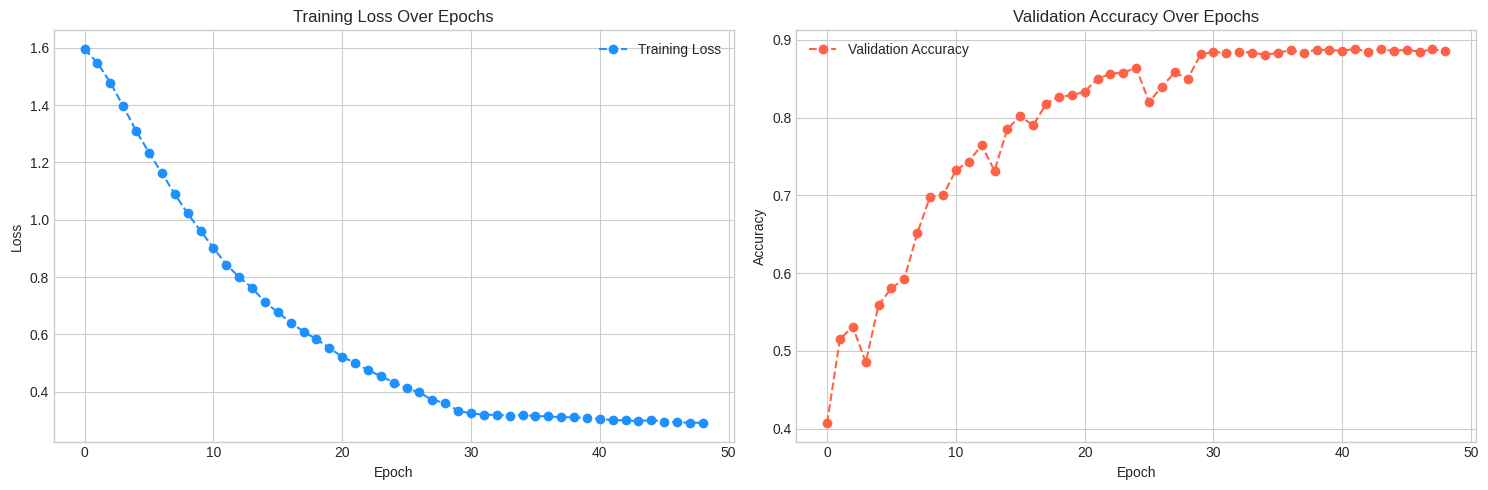

In [ ]:
# 5. Vẽ đồ thị loss và accuracy
# -------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Đồ thị Training Loss
ax1.plot(history['train_loss'], label='Training Loss', color='dodgerblue', marker='o', linestyle='--')
ax1.set_title('Training Loss Over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Đồ thị Validation Accuracy
ax2.plot(history['val_acc'], label='Validation Accuracy', color='tomato', marker='o', linestyle='--')
ax2.set_title('Validation Accuracy Over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Test

In [ ]:
# --- PHẦN 1: ĐỊNH NGHĨA VÀ TẢI DỮ LIỆU ---
data_folder = os.path.join(project_path, "test_data")
model_path = os.path.join(project_path, "best_model.pth")
output_csv_path = os.path.join(project_path, "classification_report.csv")
output_img_path = os.path.join(project_path, "confusion_matrix.png")

# Tải dữ liệu test (sử dụng lại hàm load_dataset)
print(f"Đang tải dữ liệu từ: {data_folder}")
mfccs, labels = load_dataset(data_folder)

test_dataset = EmoDataset(mfccs, labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Đã tải thành công {len(test_dataset)} mẫu test.")



Đang tải dữ liệu từ: /content/drive/MyDrive/PBL5.VN/Emotional_PBL5/test_data
🔹 Loading MFCC cache từ /content/drive/MyDrive/PBL5.VN/Emotional_PBL5/test_data/mfcc_cache.pkl
Đã tải thành công 3500 mẫu test.


Đã tải model từ '/content/drive/MyDrive/PBL5.VN/Emotional_PBL5/best_model.pth' và chuyển sang chế độ đánh giá trên cuda.
Bắt đầu dự đoán trên tập test...
Dự đoán hoàn tất.

 Tạo và lưu Classification Report...
Đã lưu thành công tại: /content/drive/MyDrive/PBL5.VN/Emotional_PBL5/classification_report.csv
              precision    recall  f1-score   support
angry          0.922844  0.871429  0.896400   700.000
happy          0.848033  0.892857  0.869868   700.000
neutral        0.938235  0.911429  0.924638   700.000
sad            0.934752  0.941429  0.938078   700.000
surprise       0.891213  0.912857  0.901905   700.000
accuracy       0.906000  0.906000  0.906000     0.906
macro avg      0.907015  0.906000  0.906178  3500.000
weighted avg   0.907015  0.906000  0.906178  3500.000

  Vẽ và lưu Confusion Matrix...


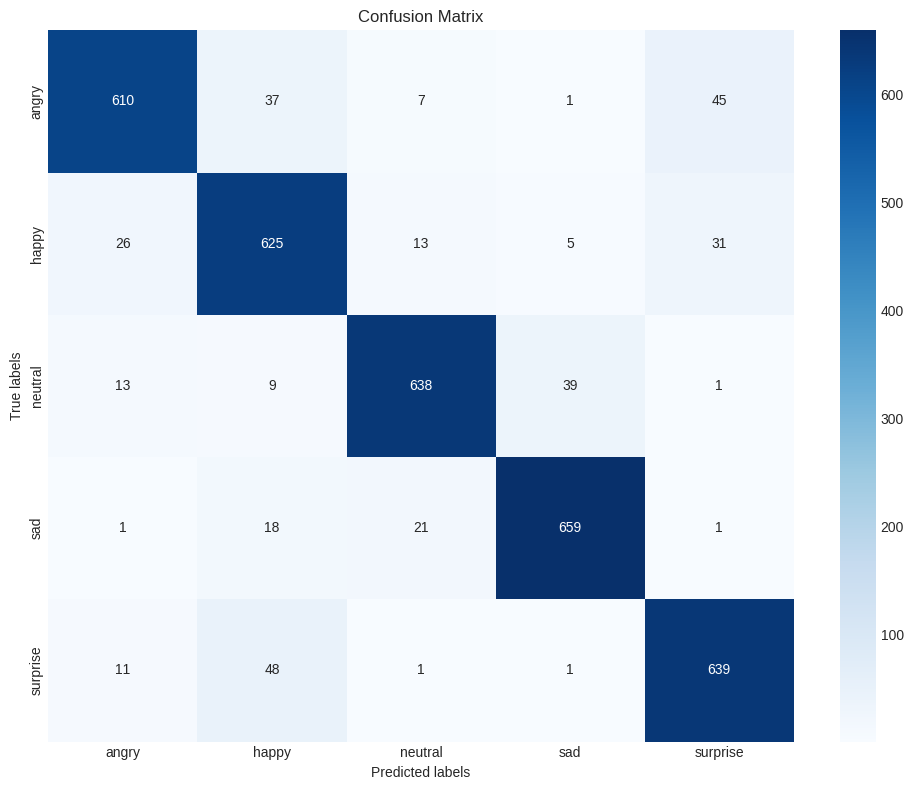

Đã lưu thành công tại: /content/drive/MyDrive/PBL5.VN/Emotional_PBL5/confusion_matrix.png

 Hoàn tất!


In [ ]:
# --- PHẦN 2: TẢI MODEL ĐÃ HUẤN LUYỆN ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Dual()
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()
print(f"Đã tải model từ '{model_path}' và chuyển sang chế độ đánh giá trên {device}.")

# --- PHẦN 3: DỰ ĐOÁN TRÊN TẬP TEST ---
print("Bắt đầu dự đoán trên tập test...")
all_labels = []
all_preds = []

with torch.no_grad():
    for mfcc, label in test_loader:
        mfcc = mfcc.unsqueeze(1).to(device)
        label = label.to(device)

        output = model(mfcc)
        _, predicted = torch.max(output, 1)

        all_labels.extend(label.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
print("Dự đoán hoàn tất.")

# --- PHẦN 4: ĐÁNH GIÁ VÀ LƯU KẾT QUẢ ---
# Đã sửa lại để có 7 cảm xúc, khớp với dữ liệu train
EMO_CLASSES = {
    0: "angry",
    1: "happy",
    2: "neutral",
    3: "sad",
    4: "surprise"
}

# 4.1. Xuất classification report ra file CSV
print("\n Tạo và lưu Classification Report...")
report = classification_report(
    all_labels,
    all_preds,
    target_names=list(EMO_CLASSES.values()),
    output_dict=True,
    zero_division=0
)

df_report = pd.DataFrame(report).transpose()
df_report.to_csv(output_csv_path, index=True, encoding="utf-8-sig")
print(f"Đã lưu thành công tại: {output_csv_path}")
# In ra màn hình để xem nhanh
print(df_report)


# 4.2. Vẽ và lưu confusion matrix thành ảnh
print("\n  Vẽ và lưu Confusion Matrix...")
cm = confusion_matrix(all_labels, all_preds, labels=list(EMO_CLASSES.keys()))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(EMO_CLASSES.values()),
            yticklabels=list(EMO_CLASSES.values()))
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.tight_layout() # Căn chỉnh cho đẹp

plt.savefig(output_img_path, dpi=300)
plt.show() # Hiển thị ảnh ngay trong notebook
plt.close()

print(f"Đã lưu thành công tại: {output_img_path}")
print("\n Hoàn tất!")

Dữ liệu tiếng Việt (Chia train/test)

**Dữ liệu tiếng Việt (Dùng K-fold)**

In [ ]:
# --- Import thư viện ---
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import librosa

# --- Import các module nội bộ ---
from utils import *
from common import *
from load_data import *
from model import *

In [ ]:
import os
import librosa
import numpy as np
from collections import Counter

# =========================================================
# BƯỚC 1. CHUẨN BỊ DỮ LIỆU
# =========================================================
avarage = 'micro'

# Đường dẫn dữ liệu thật
# data_folder = "/content/drive/MyDrive/PBL5.VN/Emotional_PBL5/data_vie/"
data_folder = "/content/drive/MyDrive/PBL5.VN/Emotional_PBL5/VNEMOS"

# =========================================================
# HÀM LOAD DỮ LIỆU TỪ FILE .WAV (ĐÃ SỬA)
# =========================================================

def load_dataset(data_folder, sr=16000, n_mfcc=40, max_len=100):
    """
    Đọc toàn bộ dữ liệu âm thanh (.wav) trong các thư mục con
    và trích xuất MFCC + gán nhãn cảm xúc theo tên thư mục.
    Chuẩn hóa độ dài MFCC để huấn luyện CNN/LSTM ổn định.
    """
    mfccs = []
    labels = []

    # Bỏ vòng lặp subfolders, đọc trực tiếp từ data_folder
    print(f"Bắt đầu quét thư mục: {data_folder}")

    # Duyệt qua các thư mục con (angry, fear, happiness,...)
    for emo_class in os.listdir(data_folder):
        emo_path = os.path.join(data_folder, emo_class)

        # Đảm bảo rằng đó là một thư mục
        if not os.path.isdir(emo_path):
            continue

        print(f"  Đang xử lý thư mục: {emo_class}")

        # Duyệt qua các file .wav trong thư mục cảm xúc
        for file in os.listdir(emo_path):
            if file.endswith('.wav'):
                file_path = os.path.join(emo_path, file)
                try:
                    y, sr_load = librosa.load(file_path, sr=sr)
                    mfcc = librosa.feature.mfcc(y=y, sr=sr_load, n_mfcc=n_mfcc)

                    # Chuẩn hóa độ dài MFCC
                    if mfcc.shape[1] < max_len:
                        pad_width = max_len - mfcc.shape[1]
                        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
                    else:
                        mfcc = mfcc[:, :max_len]

                    mfccs.append(mfcc)
                    labels.append(emo_class.lower())  # ví dụ: "angry", "happiness", ...
                except Exception as e:
                    print(f"Lỗi khi đọc {file_path}: {e}")

    mfccs = np.array(mfccs)
    labels = np.array(labels)
    print(f"Đã load {len(mfccs)} mẫu âm thanh.")
    return mfccs, labels


# --- Load dataset ---
mfccs, labels = load_dataset(data_folder)

print("Loaded samples:", len(mfccs))
print("Labels distribution:", Counter(labels))

Bắt đầu quét thư mục: /content/drive/MyDrive/PBL5.VN/Emotional_PBL5/VNEMOS
  Đang xử lý thư mục: fear
  Đang xử lý thư mục: angry
  Đang xử lý thư mục: happiness
  Đang xử lý thư mục: neutral
  Đang xử lý thư mục: sadness
Đã load 250 mẫu âm thanh.
Loaded samples: 250
Labels distribution: Counter({np.str_('fear'): 50, np.str_('angry'): 50, np.str_('happiness'): 50, np.str_('neutral'): 50, np.str_('sadness'): 50})


In [ ]:
# =========================================================
# BƯỚC 2. XỬ LÝ NHÃN
# =========================================================
EMO_CLASSES = {
    0: "angry",
    1: "fear",
    2: "happiness",
    3: "neutral",
    4: "sadness"
}
LABEL2ID = {v: k for k, v in EMO_CLASSES.items()}

# Chuyển labels dạng chữ sang số
labels = np.array([LABEL2ID[label] for label in labels])


In [ ]:
# =========================================================
# BƯỚC 3. TẠO DATASET CHO PYTORCH
# =========================================================
class EmoDataset(Dataset):
    def __init__(self, mfccs, labels):
        self.mfccs = mfccs
        self.labels = labels

    def __len__(self):
        return len(self.mfccs)

    def __getitem__(self, idx):
        x = torch.tensor(self.mfccs[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y


Device: cuda | Classes: 5

==================== Fold 1/5 ====================
Ep 05 | Loss: 1.5120 | Train Acc: 0.4300 | Val Acc: 0.3000
Ep 10 | Loss: 1.3790 | Train Acc: 0.5900 | Val Acc: 0.4800
Ep 15 | Loss: 1.1912 | Train Acc: 0.6700 | Val Acc: 0.6000
Ep 20 | Loss: 0.9670 | Train Acc: 0.8000 | Val Acc: 0.6200
Ep 25 | Loss: 0.8295 | Train Acc: 0.8700 | Val Acc: 0.6000
Ep 30 | Loss: 0.6477 | Train Acc: 0.9300 | Val Acc: 0.5800
Ep 35 | Loss: 0.5500 | Train Acc: 0.9600 | Val Acc: 0.5800
Ep 40 | Loss: 0.4422 | Train Acc: 0.9900 | Val Acc: 0.6000
Ep 45 | Loss: 0.4053 | Train Acc: 1.0000 | Val Acc: 0.6000
Ep 50 | Loss: 0.4072 | Train Acc: 0.9850 | Val Acc: 0.6200
--> Fold 1 Done. Best Val Acc: 0.6400

==================== Fold 2/5 ====================
Ep 05 | Loss: 1.5263 | Train Acc: 0.4350 | Val Acc: 0.6000
Ep 10 | Loss: 1.4131 | Train Acc: 0.6000 | Val Acc: 0.6200
Ep 15 | Loss: 1.2759 | Train Acc: 0.6550 | Val Acc: 0.6400
Ep 20 | Loss: 1.0965 | Train Acc: 0.7950 | Val Acc: 0.6600
Ep 25 

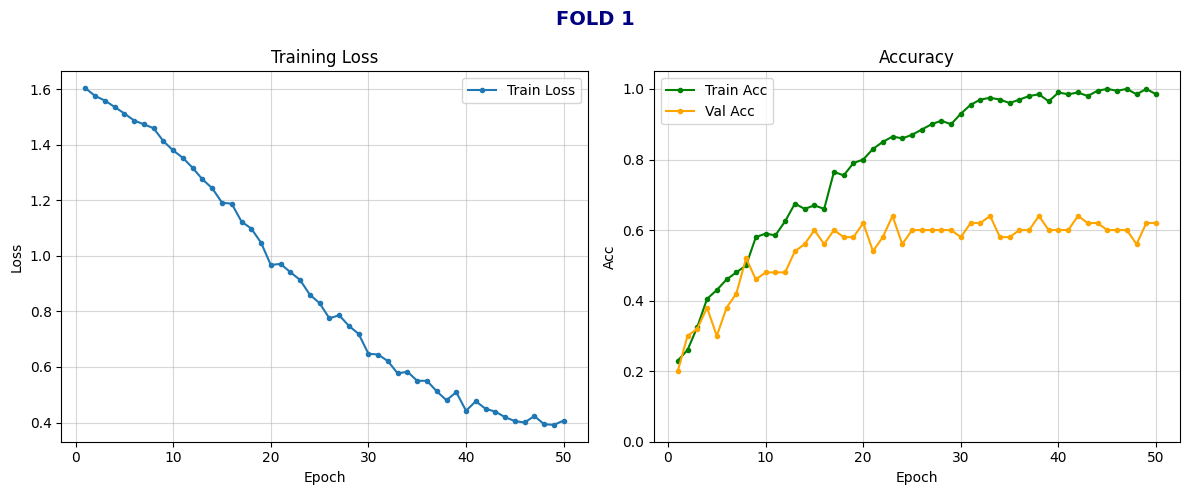

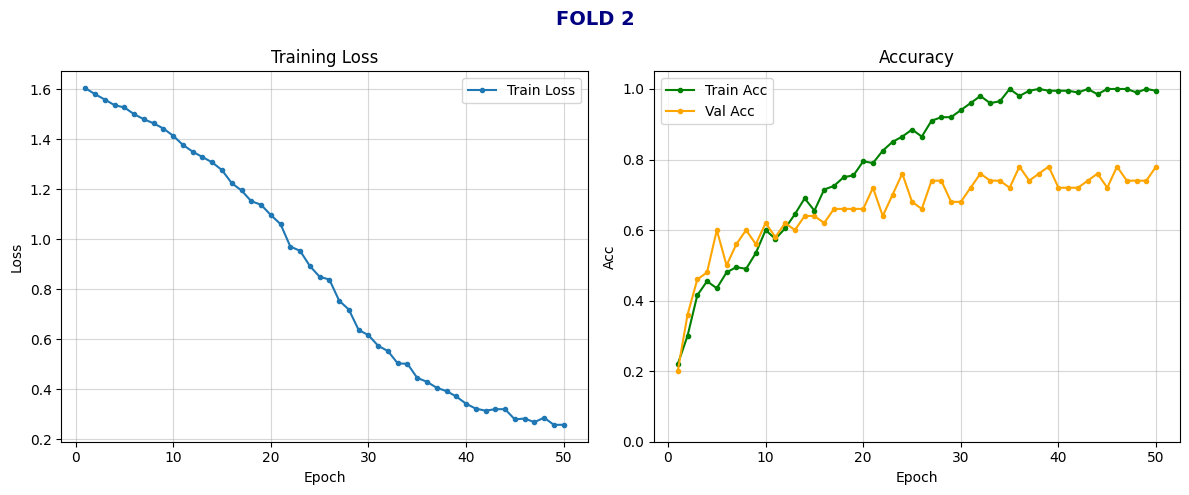

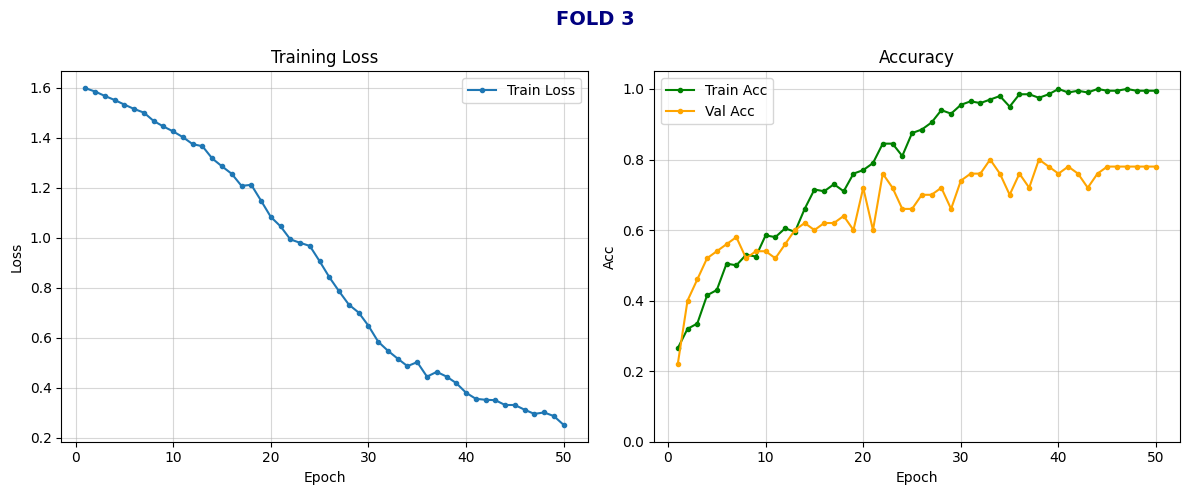

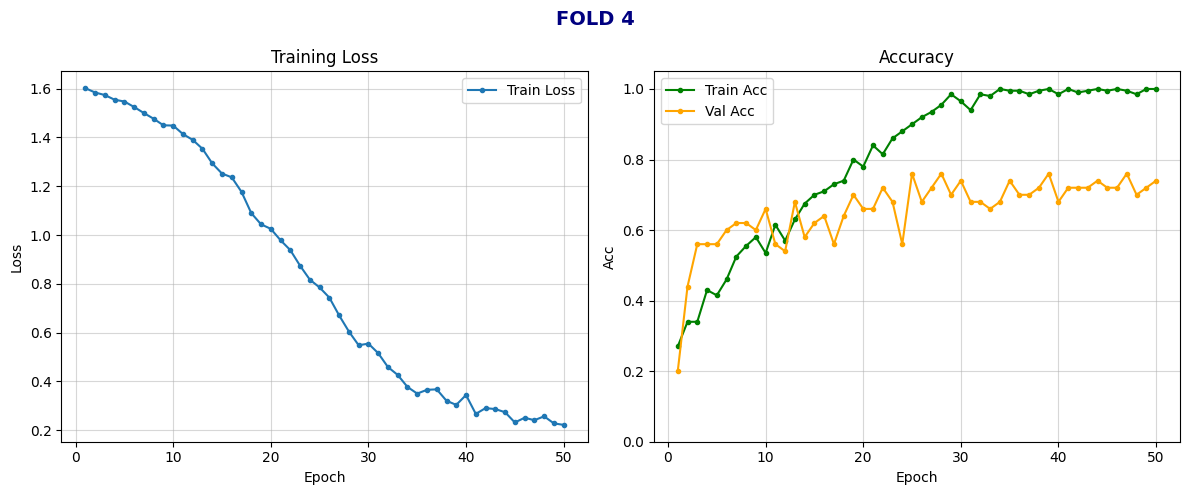

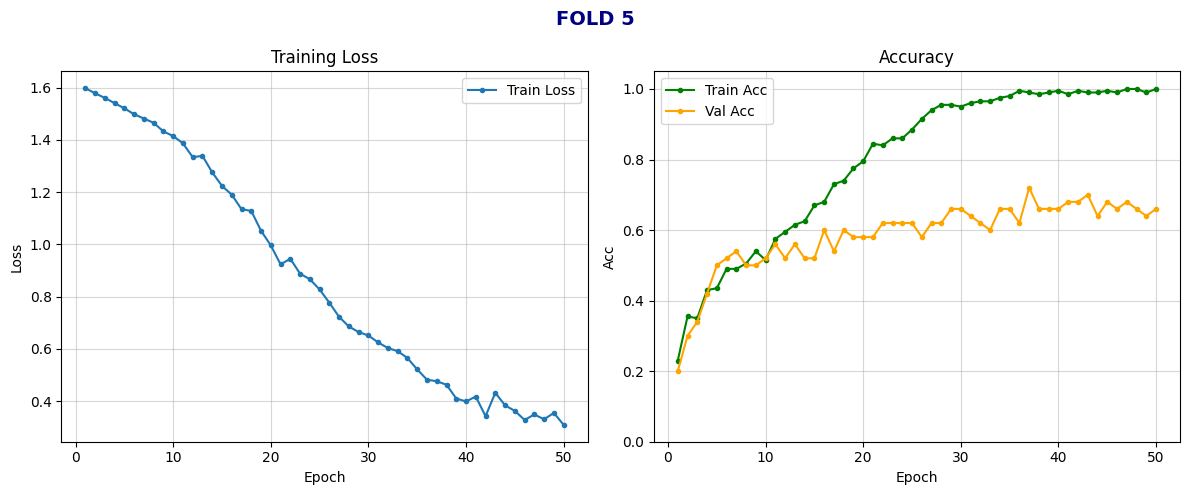

In [ ]:
# =========================================================
# BƯỚC 4. CROSS VALIDATION TRAINING (FULL CODE)
# =========================================================
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# --- Hyperparameters ---
epochs = 50
batch_size = 16
learning_rate = 1e-4
weight_decay = 1e-4  # Chống overfitting
average_method = 'micro'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.CrossEntropyLoss()

# --- Biến lưu kết quả K-Fold ---
acc_kfold, f1_kfold, recall_kfold, precision_kfold = [], [], [], []
labels_preds_kfold = []

# Biến lưu lịch sử để vẽ biểu đồ
losses_kfold = []       # Train Loss
train_acc_kfold = []    # Train Acc
val_acc_kfold = []      # Val Acc

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Chuyển đổi dữ liệu sang numpy
if isinstance(mfccs, list): mfccs = np.array(mfccs)
if isinstance(labels, list): labels = np.array(labels)

num_classes = len(np.unique(labels))
print(f"Device: {device} | Classes: {num_classes}")

for idx, (train_idx, test_idx) in enumerate(skf.split(mfccs, labels)):
    print(f"\n{'='*20} Fold {idx+1}/{skf.n_splits} {'='*20}")

    # Chia dữ liệu
    mfcc_train, mfcc_test = mfccs[train_idx], mfccs[test_idx]
    train_labels, test_labels = labels[train_idx], labels[test_idx]

    train_dataset = EmoDataset(mfcc_train, train_labels)
    test_dataset = EmoDataset(mfcc_test, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Khởi tạo model & optimizer
    model = Dual(num_classes=num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Scheduler giảm LR nếu val_acc không tăng
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.75, patience=3
    )

    best_acc = 0.0
    best_metrics = {'f1': 0, 'recall': 0, 'precision': 0, 'labels': [], 'preds': []}

    # Lịch sử từng fold
    fold_train_losses = []
    fold_train_accs = []
    fold_val_accs = []

    for epoch in range(epochs):
        # -------- Train --------
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0

        for mfcc, label in train_loader:
            mfcc = mfcc.unsqueeze(1).to(device)
            label = label.to(device)

            optimizer.zero_grad()
            output = model(mfcc)
            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Tính Train Acc
            _, predicted = torch.max(output, 1)
            correct_train += (predicted == label).sum().item()
            total_train += label.size(0)

        avg_loss = total_loss / len(train_loader)
        train_acc = correct_train / total_train

        fold_train_losses.append(avg_loss)
        fold_train_accs.append(train_acc)

        # -------- Validation --------
        model.eval()
        all_labels, all_preds = [], []
        with torch.no_grad():
            for mfcc, label in test_loader:
                mfcc = mfcc.unsqueeze(1).to(device)
                label = label.to(device)
                output = model(mfcc)
                _, predicted = torch.max(output, 1)
                all_labels.extend(label.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_acc = accuracy_score(all_labels, all_preds)
        fold_val_accs.append(val_acc)

        scheduler.step(val_acc)

        # Lưu Best Model
        if val_acc > best_acc:
            best_acc = val_acc
            best_metrics['f1'] = f1_score(all_labels, all_preds, average=average_method, zero_division=0)
            best_metrics['recall'] = recall_score(all_labels, all_preds, average=average_method, zero_division=0)
            best_metrics['precision'] = precision_score(all_labels, all_preds, average=average_method, zero_division=0)
            best_metrics['labels'] = list(all_labels)
            best_metrics['preds'] = list(all_preds)
            print(f"   -> Lưu mô hình mới (Epoch: {epoch:02d}) (Val Acc: {best_acc:.4f})")

        if (epoch + 1) % 5 == 0:
            print(f"Ep {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # --- Lưu kết quả Fold ---
    acc_kfold.append(best_acc)
    f1_kfold.append(best_metrics['f1'])
    recall_kfold.append(best_metrics['recall'])
    precision_kfold.append(best_metrics['precision'])
    labels_preds_kfold.append([best_metrics['labels'], best_metrics['preds']])

    losses_kfold.append(fold_train_losses)
    train_acc_kfold.append(fold_train_accs)
    val_acc_kfold.append(fold_val_accs)

    print(f"--> Fold {idx+1} Done. Best Val Acc: {best_acc:.4f}")

print(f"\nDONE! Mean Accuracy: {np.mean(acc_kfold):.4f}")

# =========================================================
# VẼ BIỂU ĐỒ TỪNG FOLD
# =========================================================
print("\n========== BIỂU ĐỒ HUẤN LUYỆN ==========")
for i in range(len(losses_kfold)):
    epochs_range = range(1, len(losses_kfold[i]) + 1)

    plt.figure(figsize=(12, 5))
    plt.suptitle(f"FOLD {i+1}", fontsize=14, fontweight='bold', color='navy')

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, losses_kfold[i], '.-', label='Train Loss')
    plt.title(f"Training Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True, alpha=0.5); plt.legend()

    # Accuracy (So sánh Train vs Val)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_acc_kfold[i], '.-', color='green', label='Train Acc')
    plt.plot(epochs_range, val_acc_kfold[i], '.-', color='orange', label='Val Acc')
    plt.title(f"Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.ylim(0, 1.05); plt.grid(True, alpha=0.5); plt.legend()

    plt.tight_layout()
    plt.show()

--- Đánh giá từng Fold ---

--- FOLD 1 ---
              precision    recall  f1-score   support

       angry       0.67      0.40      0.50        10
        fear       0.50      0.70      0.58        10
   happiness       0.55      0.60      0.57        10
     neutral       0.78      0.70      0.74        10
     sadness       0.80      0.80      0.80        10

    accuracy                           0.64        50
   macro avg       0.66      0.64      0.64        50
weighted avg       0.66      0.64      0.64        50



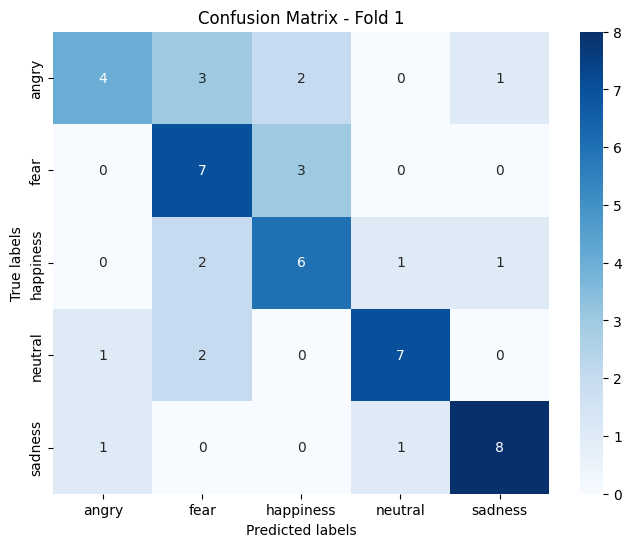


--- FOLD 2 ---
              precision    recall  f1-score   support

       angry       0.80      0.80      0.80        10
        fear       0.71      1.00      0.83        10
   happiness       0.64      0.90      0.75        10
     neutral       1.00      0.70      0.82        10
     sadness       1.00      0.50      0.67        10

    accuracy                           0.78        50
   macro avg       0.83      0.78      0.77        50
weighted avg       0.83      0.78      0.77        50



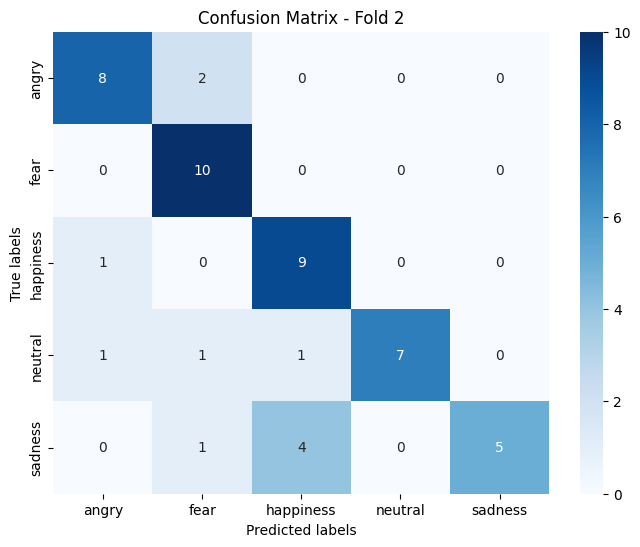


--- FOLD 3 ---
              precision    recall  f1-score   support

       angry       1.00      0.70      0.82        10
        fear       0.86      0.60      0.71        10
   happiness       0.69      0.90      0.78        10
     neutral       0.83      1.00      0.91        10
     sadness       0.73      0.80      0.76        10

    accuracy                           0.80        50
   macro avg       0.82      0.80      0.80        50
weighted avg       0.82      0.80      0.80        50



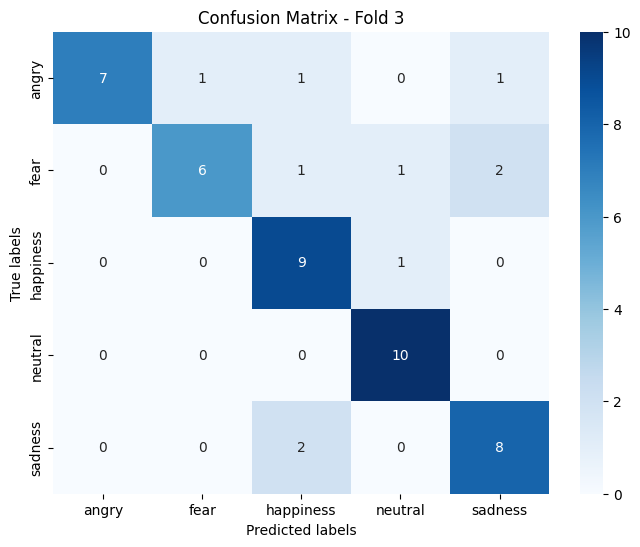


--- FOLD 4 ---
              precision    recall  f1-score   support

       angry       0.83      0.50      0.62        10
        fear       0.69      0.90      0.78        10
   happiness       0.64      0.70      0.67        10
     neutral       0.82      0.90      0.86        10
     sadness       0.89      0.80      0.84        10

    accuracy                           0.76        50
   macro avg       0.77      0.76      0.75        50
weighted avg       0.77      0.76      0.75        50



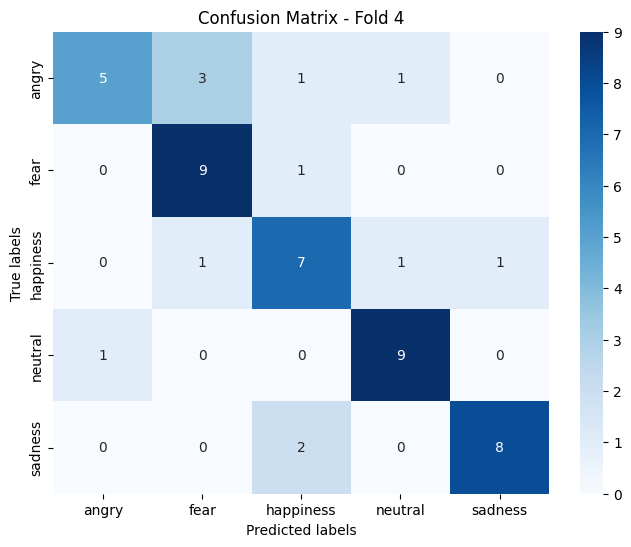


--- FOLD 5 ---
              precision    recall  f1-score   support

       angry       0.46      0.60      0.52        10
        fear       0.75      0.30      0.43        10
   happiness       0.80      0.80      0.80        10
     neutral       1.00      1.00      1.00        10
     sadness       0.69      0.90      0.78        10

    accuracy                           0.72        50
   macro avg       0.74      0.72      0.71        50
weighted avg       0.74      0.72      0.71        50



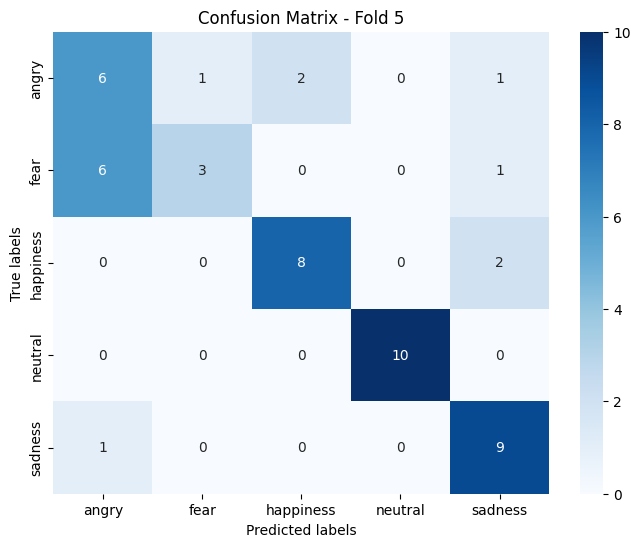


--- BÁO CÁO TỔNG HỢP (TRUNG BÌNH CÁC FOLD) ---

Fold 0:
              precision    recall  f1-score   support

       angry       0.67      0.40      0.50        10
        fear       0.50      0.70      0.58        10
   happiness       0.55      0.60      0.57        10
     neutral       0.78      0.70      0.74        10
     sadness       0.80      0.80      0.80        10

    accuracy                           0.64        50
   macro avg       0.66      0.64      0.64        50
weighted avg       0.66      0.64      0.64        50


Fold 1:
              precision    recall  f1-score   support

       angry       0.80      0.80      0.80        10
        fear       0.71      1.00      0.83        10
   happiness       0.64      0.90      0.75        10
     neutral       1.00      0.70      0.82        10
     sadness       1.00      0.50      0.67        10

    accuracy                           0.78        50
   macro avg       0.83      0.78      0.77        50
weighted av

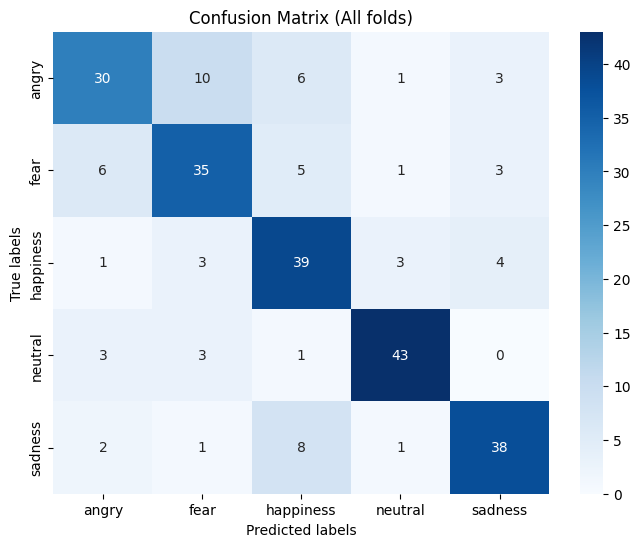


Unweighted Accuracy (UA) Tổng hợp: 0.7400
Weighted Accuracy (WA) Tổng hợp: 0.7400


In [ ]:
# Import các thư viện cần thiết để vẽ
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# =========================================================
# 1. IN CONFUSION MATRIX CỦA TỪNG FOLD
# =========================================================
print("--- Đánh giá từng Fold ---")

# Giả sử labels_preds_kfold là một list:
# [ [y_true_fold1, y_pred_fold1],
#   [y_true_fold2, y_pred_fold2], ... ]

for i, fold_results in enumerate(labels_preds_kfold):

    # --- SỬA LỖI TẠI ĐÂY ---
    # Truy cập bằng chỉ số 0 và 1, không phải string 'true' và 'pred'
    y_true_fold = fold_results[0]
    y_pred_fold = fold_results[1]
    # -----------------------

    print(f"\n--- FOLD {i+1} ---")

    # 1.1. In Classification Report cho từng fold
    print(classification_report(
        y_true_fold,
        y_pred_fold,
        target_names=list(EMO_CLASSES.values()),
        labels=list(EMO_CLASSES.keys()),
        zero_division=0
    ))

    # 1.2. Vẽ Confusion Matrix cho từng fold
    cm = confusion_matrix(
        y_true_fold,
        y_pred_fold,
        labels=list(EMO_CLASSES.keys())
    )

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=list(EMO_CLASSES.values()),
        yticklabels=list(EMO_CLASSES.values())
    )
    plt.title(f"Confusion Matrix - Fold {i+1}")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.show()


# =========================================================
# 2. IN BÁO CÁO TỔNG HỢP (TRUNG BÌNH CÁC FOLD)
# =========================================================
print("\n" + "="*40)
print("--- BÁO CÁO TỔNG HỢP (TRUNG BÌNH CÁC FOLD) ---")
print("="*40)

# (Các hàm báo cáo tổng hợp của bạn giữ nguyên)
print_classification_report(
    labels_preds_kfold,
    target_names=list(EMO_CLASSES.values()),
    labels=list(EMO_CLASSES.keys())
)

average_classification_report(
    labels_preds_kfold,
    target_names=list(EMO_CLASSES.values()),
    labels=list(EMO_CLASSES.keys())
)

print("\n--- Ma trận nhầm lẫn tổng hợp (Tất cả các Fold) ---")
plot_confusion_matrix(
    labels_preds_kfold,
    labels=list(EMO_CLASSES.keys()),
    target_names=list(EMO_CLASSES.values())
)

ua, wa = compute_ua_wa(labels_preds_kfold)
print(f"\nUnweighted Accuracy (UA) Tổng hợp: {ua:.4f}")
print(f"Weighted Accuracy (WA) Tổng hợp: {wa:.4f}")